In [96]:
import numpy as np
import pandas as pd
from tabulate import tabulate


In [97]:
df=pd.read_csv('laptop_data.csv')
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [98]:

def explore_data(df):
    # Shape of DataFrame
    shape_headers = ["Number of Rows", "Number of Columns"]
    shape_data = [(df.shape[0], df.shape[1])]
    
    # Info of DataFrame
    info_data = []
    for col in df.columns:
        info_data.append((col, df[col].count(), df[col].dtype))
    
    # Data Types
    dtypes_headers = ["Column", "Data Type"]
    dtypes_data = [(col, df[col].dtype) for col in df.columns]
    
    # Missing Values
    missing_values = df.isnull().sum()
    missing_headers = ["Column", "Missing Values"]
    missing_data = [(col, count if count != 0 else "Zero") for col, count in missing_values.items()]
    
    # Summary Statistics
    summary_stats = df.describe()
    
    # Value Counts Column-wise
    value_counts_data = []
    for column in df.columns:
        counts = df[column].value_counts().reset_index()
        counts.columns = ['Value', 'Count']
        value_counts_data.append((f"Value Counts for {column}", counts))

    # Displaying results using tabulate
    print("\n\n~~~~~ Shape of DataFrame ~~~~~")
    print(tabulate(shape_data, headers=shape_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Info of DataFrame ~~~~~")
    print(tabulate(info_data, headers=["Column", "Non-Null Count", "Dtype"], tablefmt="grid"))

    print("\n\n~~~~~ Data Types ~~~~~")
    print(tabulate(dtypes_data, headers=dtypes_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Missing Values ~~~~~")
    print(tabulate(missing_data, headers=missing_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Summary Statistics ~~~~~")
    print(tabulate(summary_stats, headers='keys', tablefmt="grid"))



explore_data(df)




~~~~~ Shape of DataFrame ~~~~~
+----------------+-------------------+
| Number of Rows | Number of Columns |
+----------------+-------------------+
|      1303      |        12         |
+----------------+-------------------+


~~~~~ Info of DataFrame ~~~~~
+------------------+------------------+---------+
| Column           |   Non-Null Count | Dtype   |
+==================+==================+=========+
| Unnamed: 0       |             1303 | int64   |
+------------------+------------------+---------+
| Company          |             1303 | object  |
+------------------+------------------+---------+
| TypeName         |             1303 | object  |
+------------------+------------------+---------+
| Inches           |             1303 | float64 |
+------------------+------------------+---------+
| ScreenResolution |             1303 | object  |
+------------------+------------------+---------+
| Cpu              |             1303 | object  |
+------------------+------------------+-

In [99]:
df.drop(columns='Unnamed: 0',inplace=True)
df['Ram']=df['Ram'].str.strip("GB")
df['Ram']=df['Ram'].astype(int)
df['Weight']=df['Weight'].str.strip("kg")
df['Weight']=df['Weight'].astype(float)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float64
 10  Price             1303 non-null   float64
dtypes: float64(3), int32(1), object(7)
memory usage: 107.0+ KB


<Figure size 1000x600 with 0 Axes>

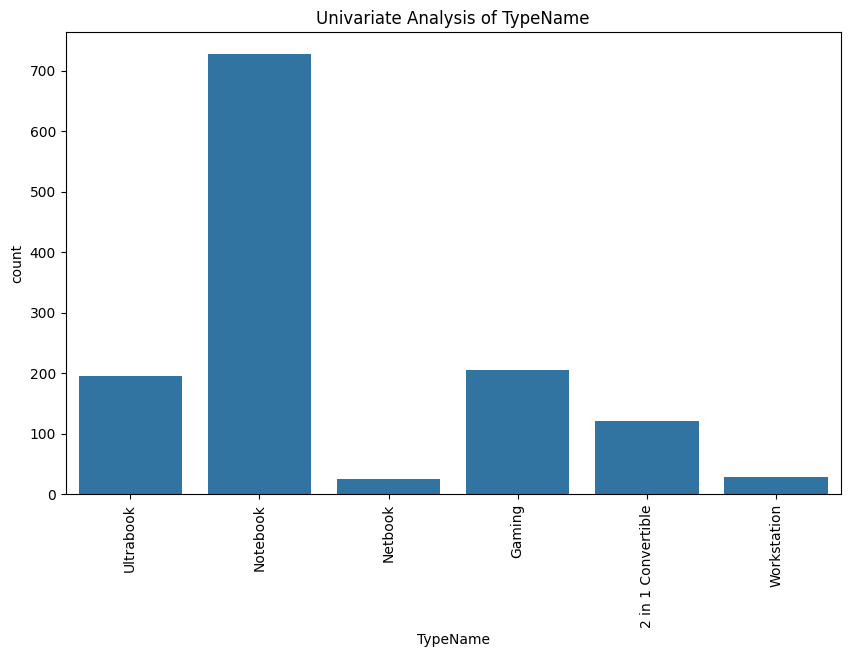

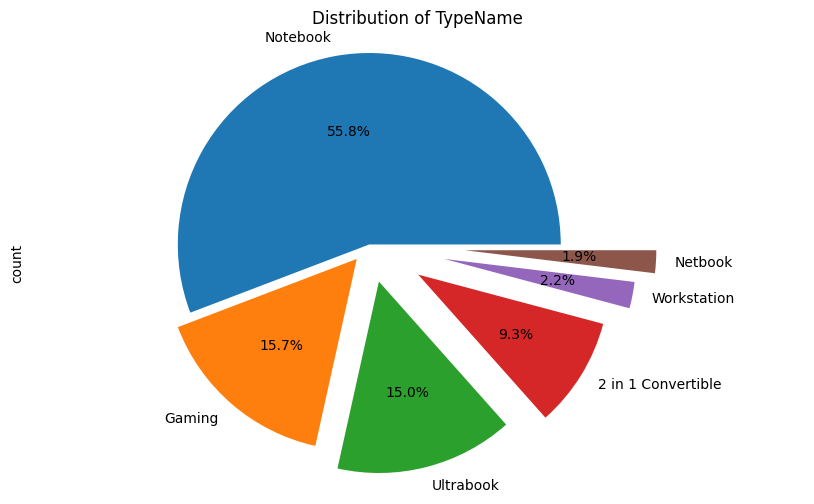

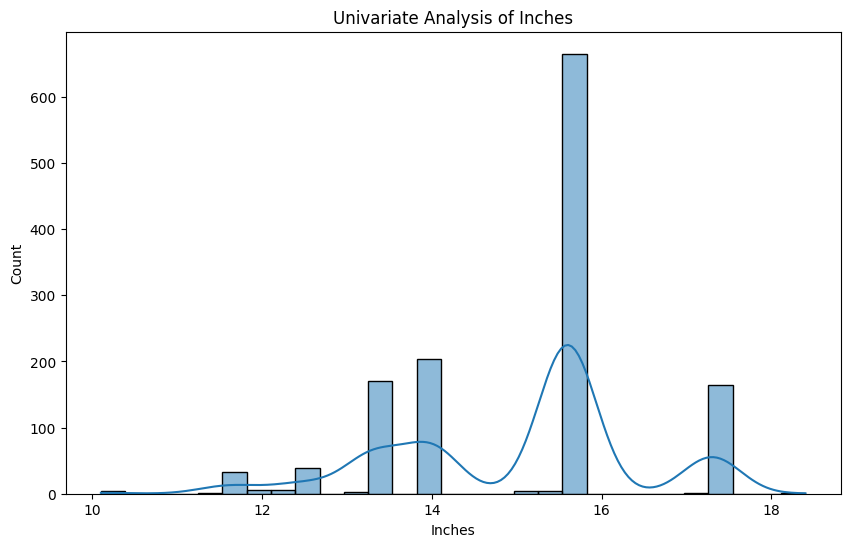

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

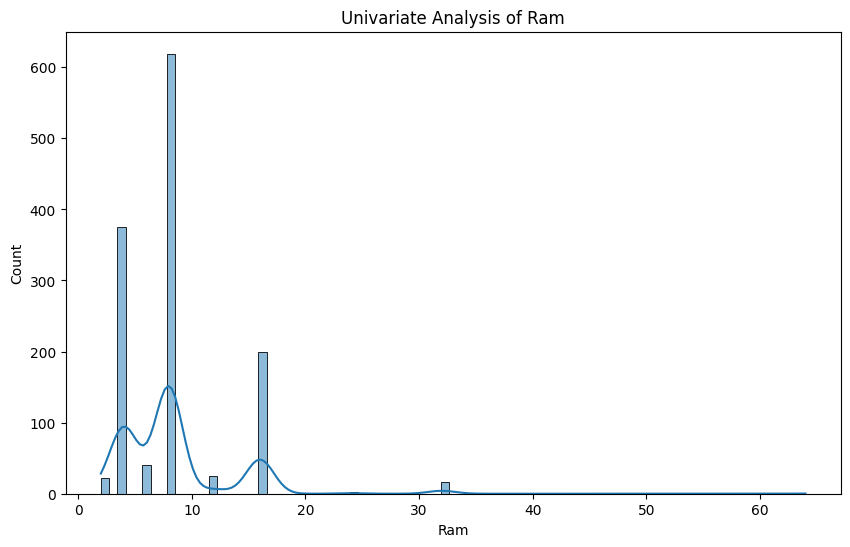

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

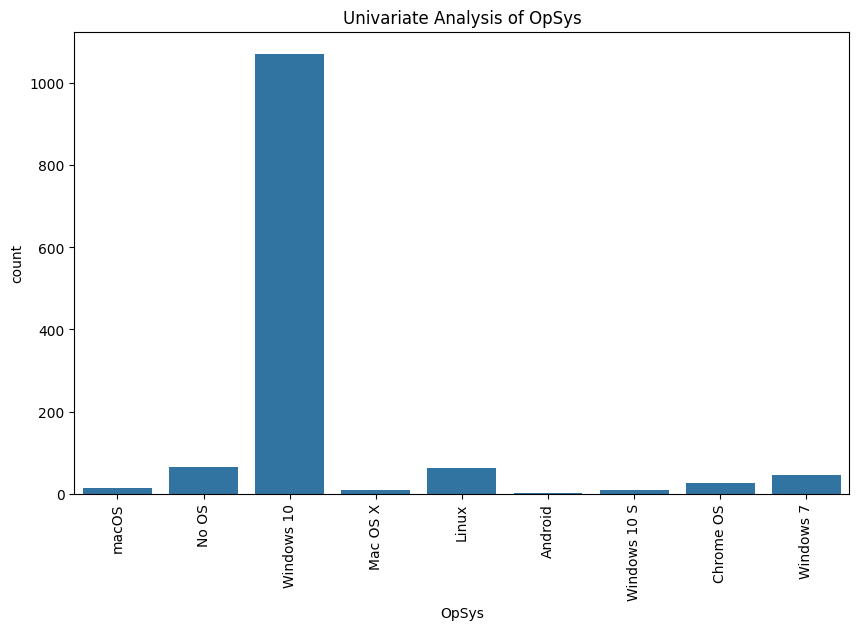

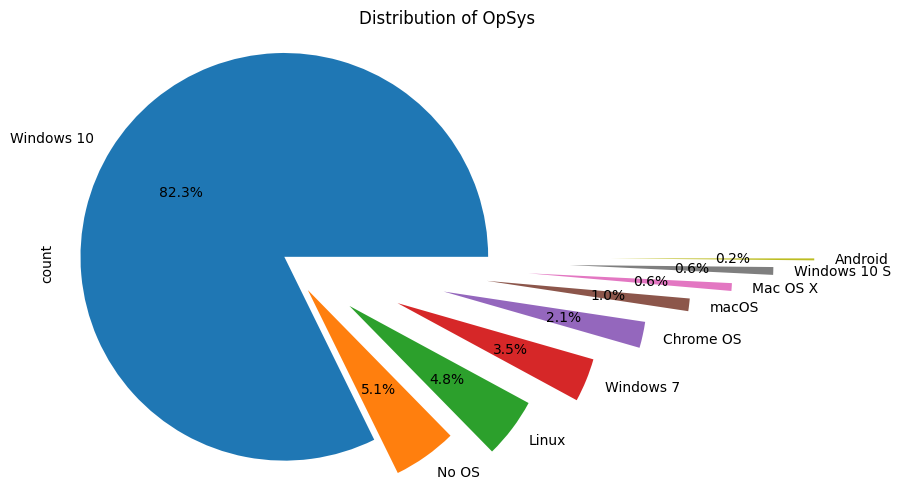

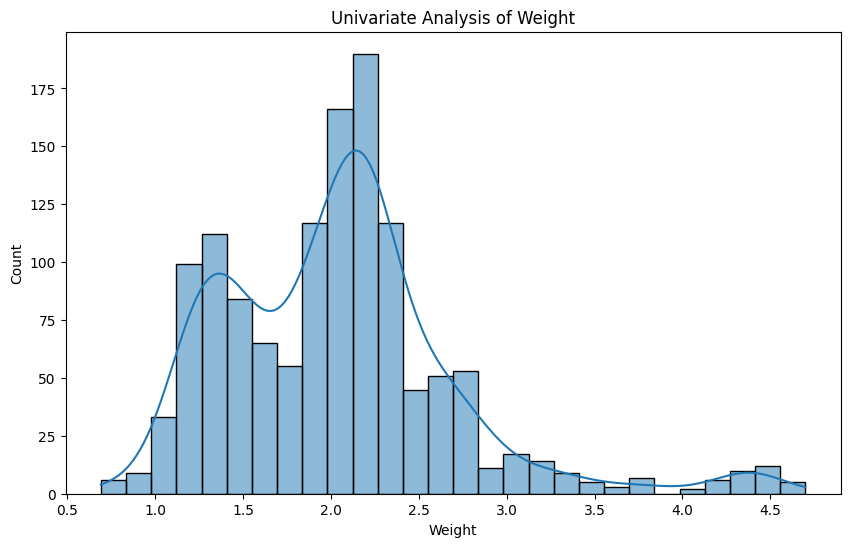

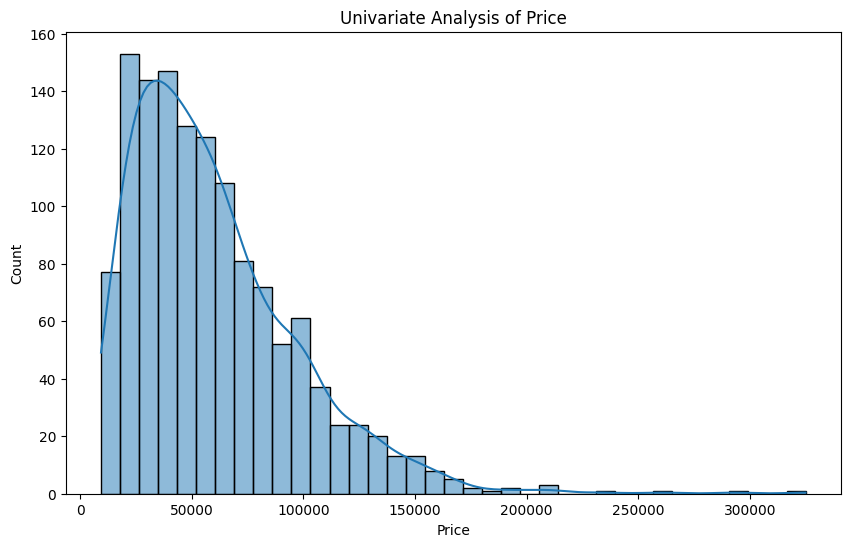

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def univariate_analysis(df):
    """
    Perform univariate analysis on all columns of the dataframe.

    Parameters:
    - df: DataFrame
    """
    univariate_count = 0
    explode_factor = 0.1
    for column in df.columns:
        if univariate_count >= 30:  # Adjust the count as needed
            break
        plt.figure(figsize=(10, 6))
        if df[column].dtype == 'object':
            unique_values = df[column].nunique()
            if unique_values <= 10:
                sns.countplot(data=df, x=column)
                plt.xticks(rotation=90)
                plt.title(f'Univariate Analysis of {column}')
                plt.show()
                univariate_count += 1
                plt.figure(figsize=(10, 6))
                counts = df[column].value_counts()
                explode = [explode_factor * i for i in range(len(counts))]
                counts.plot(kind='pie', autopct='%1.1f%%', explode=explode)
                plt.title(f'Distribution of {column}')
                plt.axis('equal')
                plt.show()
                univariate_count += 1
                explode_factor += 0.1
            elif unique_values <= 7:
                plt.figure(figsize=(10, 6))
                counts = df[column].value_counts()
                explode = [explode_factor * i for i in range(len(counts))]
                counts.plot(kind='pie', autopct='%1.1f%%', explode=explode)
                plt.title(f'Distribution of {column}')
                plt.axis('equal')
                plt.show()
                univariate_count += 1
                explode_factor += 0.1
        else:
            sns.histplot(data=df, x=column, kde=True)
            plt.title(f'Univariate Analysis of {column}')
            plt.show()
            univariate_count += 1

univariate_analysis(df)


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_analysis(df, x_column, y_column):
    """
    Perform bivariate analysis between two columns of the dataframe.

    Parameters:
    - df: DataFrame
    - x_column: str, name of the first column
    - y_column: str, name of the second column
    """
    plt.figure(figsize=(10, 6))
    if df[x_column].dtype == 'object' and df[y_column].dtype == 'object':
        sns.barplot(data=df, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Barplot between {x_column} and {y_column}')
        plt.show()
    elif df[x_column].dtype == 'object':
        sns.violinplot(data=df, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Violinplot between {x_column} and {y_column}')
        plt.show()
    elif df[y_column].dtype == 'object':
        sns.violinplot(data=df, x=y_column, y=x_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Violinplot between {y_column} and {x_column}')
        plt.show()
    else:
        sns.lineplot(data=df, x=x_column, y=y_column)
        plt.title(f'Bivariate Lineplot between {x_column} and {y_column}')
        plt.show()


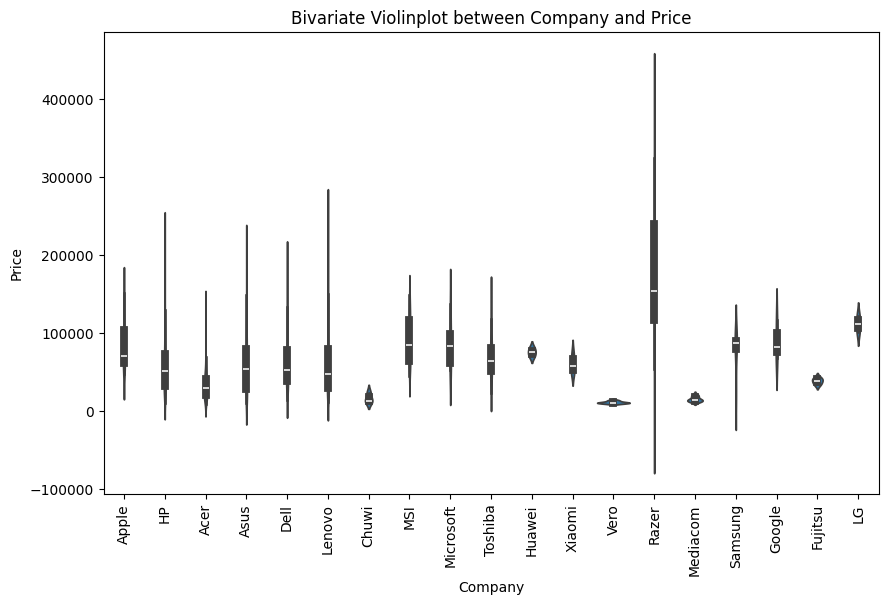

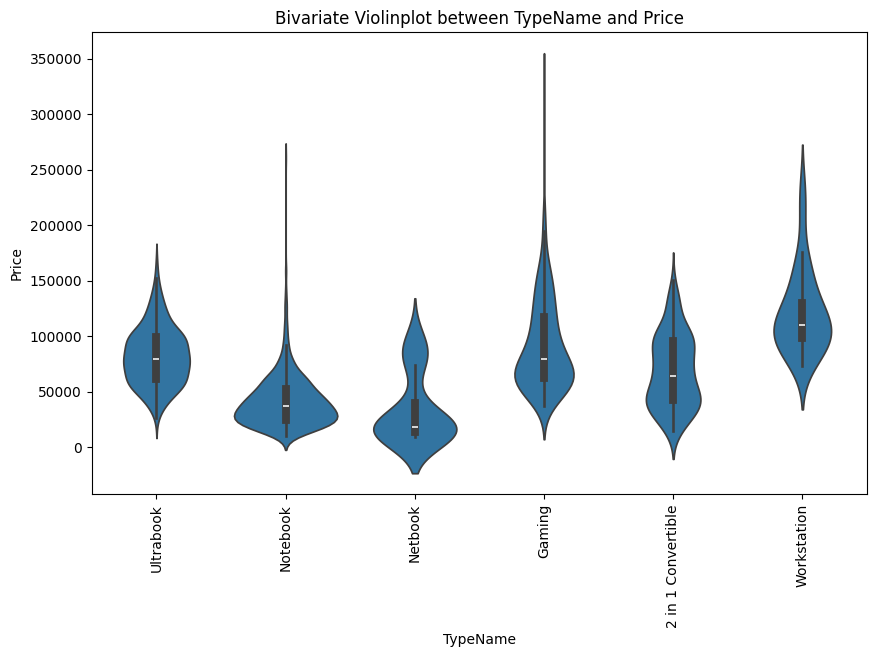

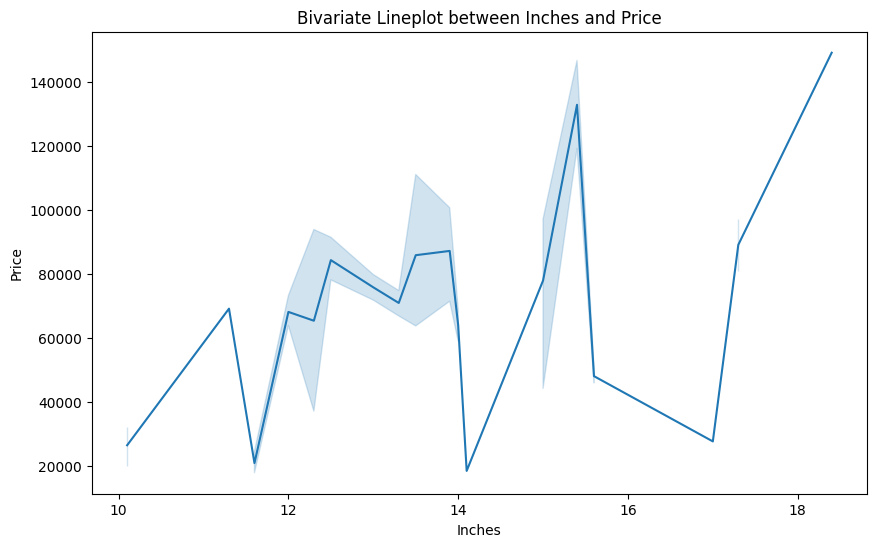

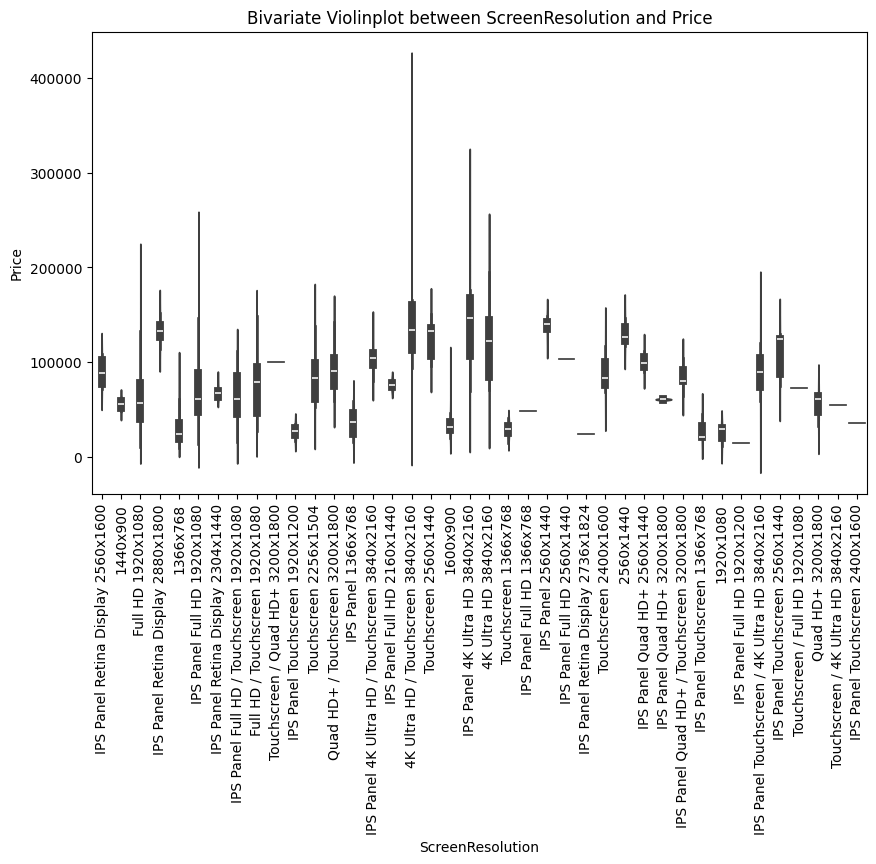

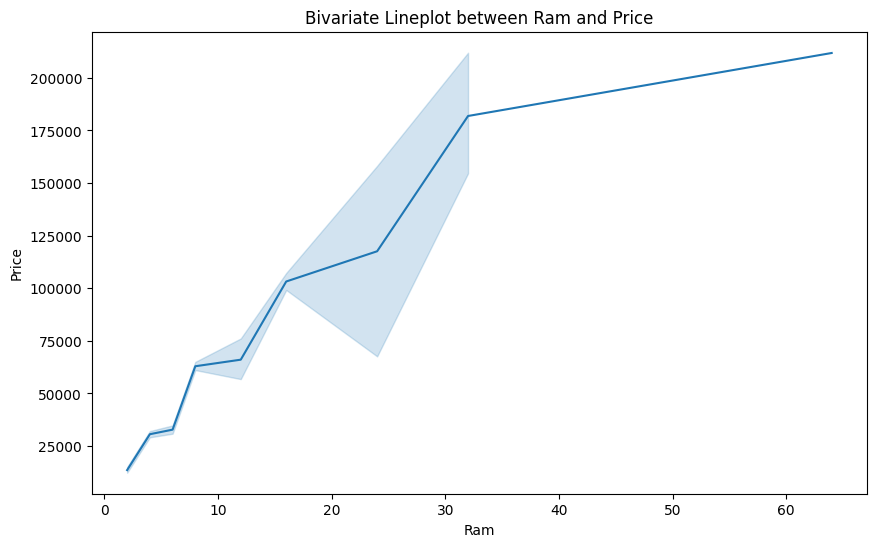

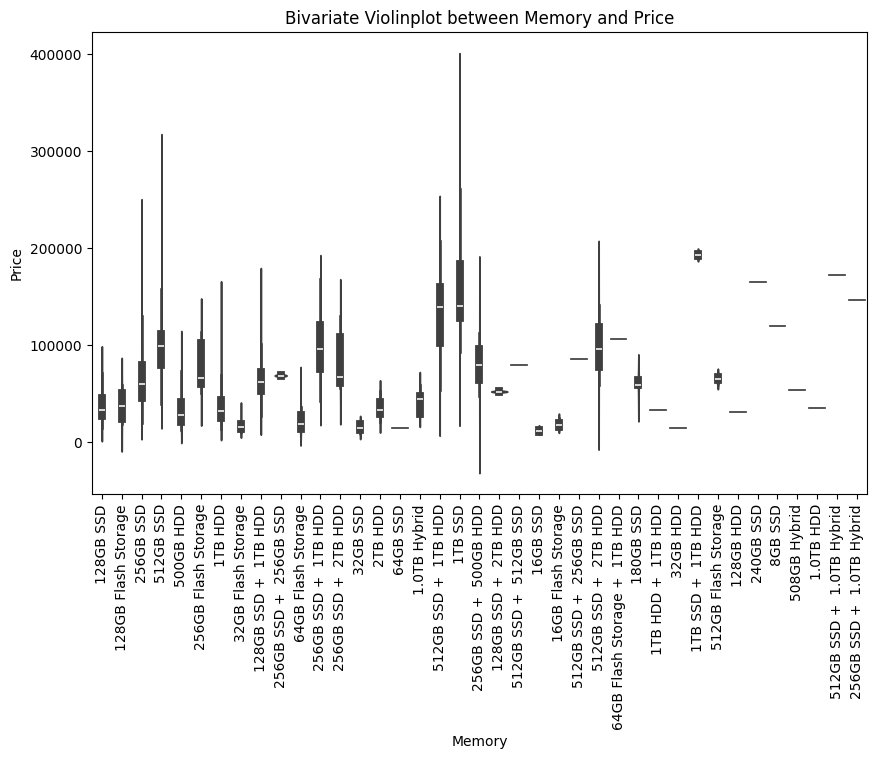

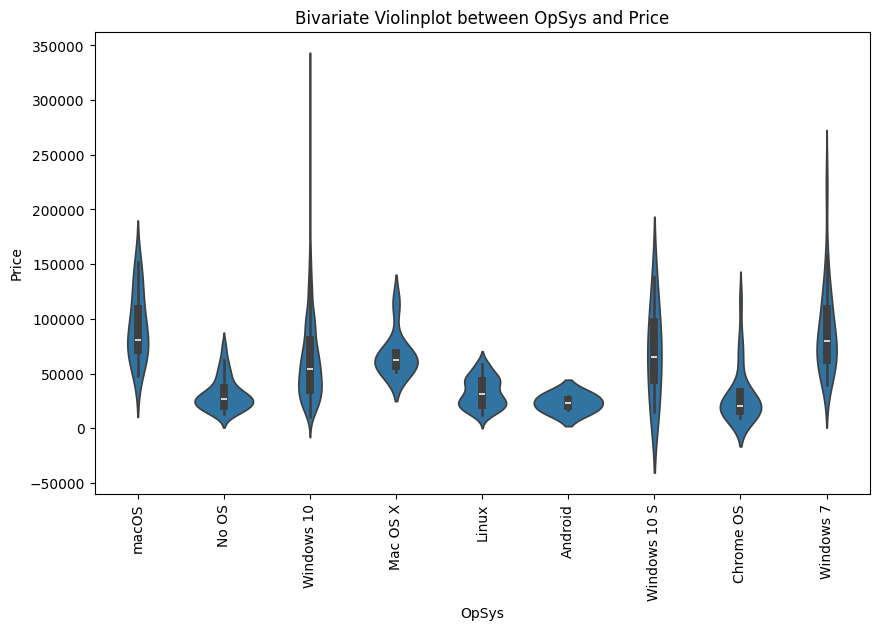

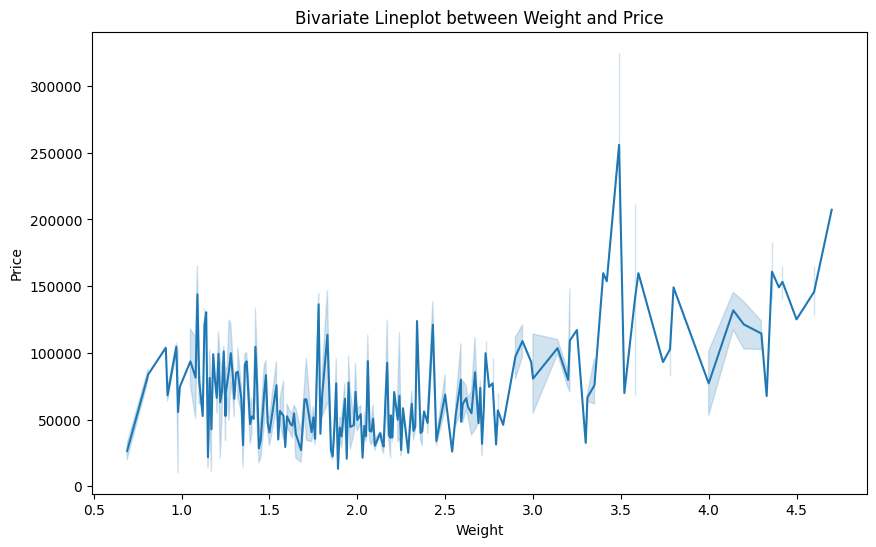

In [103]:
bivariate_analysis(df, 'Company', 'Price')
bivariate_analysis(df, 'TypeName', 'Price')
bivariate_analysis(df, 'Inches', 'Price')
bivariate_analysis(df, 'ScreenResolution', 'Price')
bivariate_analysis(df, 'Ram', 'Price')
bivariate_analysis(df, 'Memory', 'Price')
bivariate_analysis(df, 'OpSys', 'Price')
bivariate_analysis(df, 'Weight', 'Price')

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_analysis(df, x_column, y_column):
    """
    Perform bivariate analysis between two columns of the dataframe.

    Parameters:
    - df: DataFrame
    - x_column: str, name of the first column
    - y_column: str, name of the second column
    """
    plt.figure(figsize=(10, 6))
    if df[x_column].dtype == 'object' and df[y_column].dtype == 'object':
        sns.barplot(data=df, x=x_column, y=y_column, estimator=np.mean, ci=None)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Barplot (mean) between {x_column} and {y_column}')
        plt.show()
    elif df[x_column].dtype == 'object':
        top_categories = df.groupby(x_column)[y_column].mean().nlargest(10).index
        df_filtered = df[df[x_column].isin(top_categories)]
        sns.boxplot(data=df_filtered, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Boxplot between {x_column} and {y_column}')
        plt.show()
    elif df[y_column].dtype == 'object':
        top_categories = df.groupby(y_column)[x_column].mean().nlargest(10).index
        df_filtered = df[df[y_column].isin(top_categories)]
        sns.boxplot(data=df_filtered, x=y_column, y=x_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Boxplot between {y_column} and {x_column}')
        plt.show()
    else:
        sns.scatterplot(data=df, x=x_column, y=y_column)
        plt.title(f'Bivariate Scatterplot between {x_column} and {y_column}')
        plt.show()


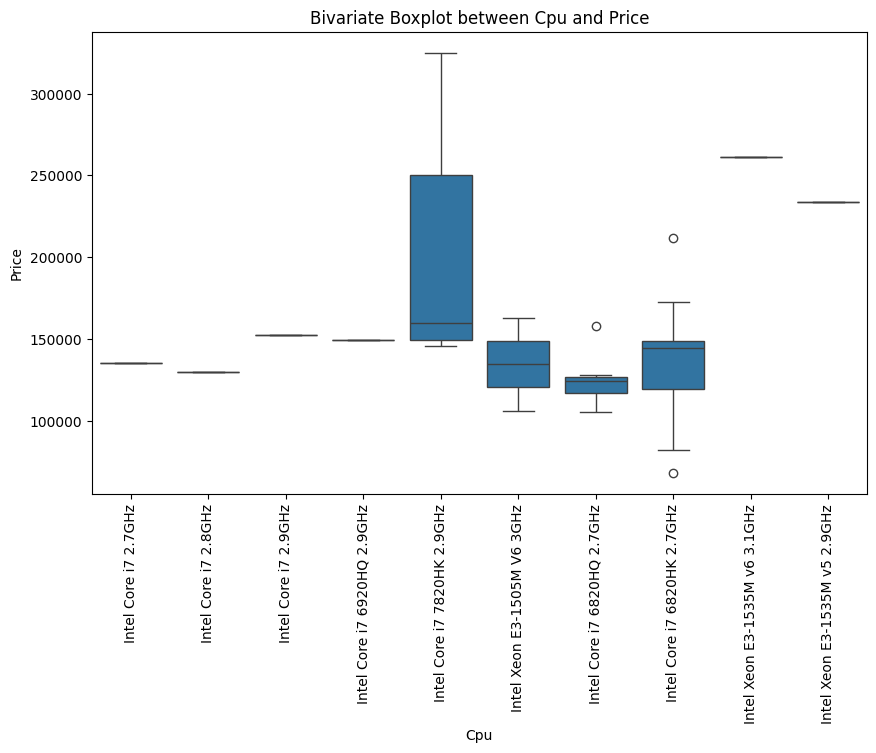

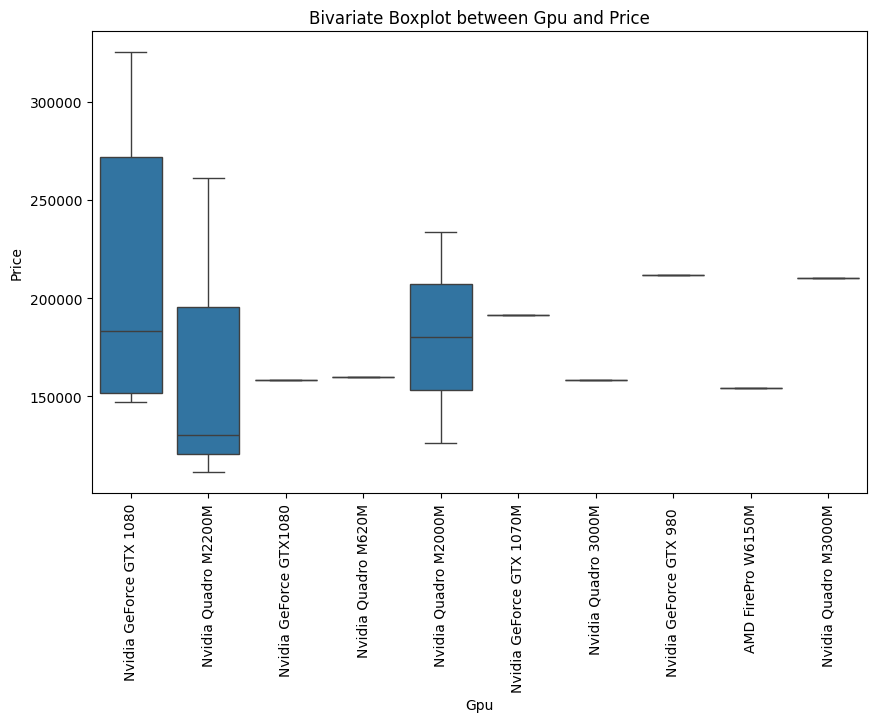

In [105]:
bivariate_analysis(df, 'Cpu', 'Price')
bivariate_analysis(df, 'Gpu', 'Price')

In [106]:
import seaborn as sns

def multivariate_analysis(df, columns):
    """
    Perform multivariate analysis using pairplot.

    Parameters:
    - df: DataFrame
    - columns: list of str, names of the columns to analyze
    """
    sns.pairplot(df[columns])
    plt.title('Multivariate Analysis')
    plt.show()


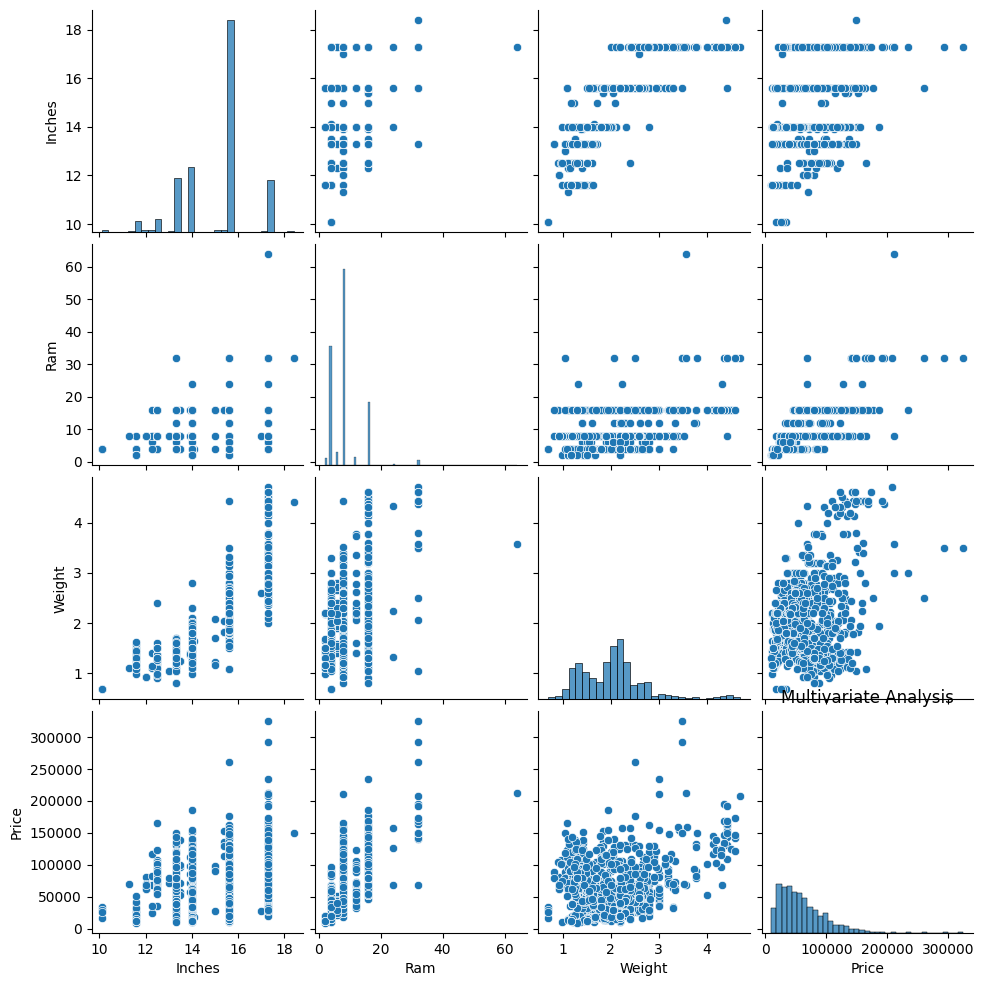

In [107]:
multivariate_analysis(df, ['Inches', 'Ram', 'Weight', 'Price'])

In [108]:
import matplotlib.pyplot as plt

def lineplot_impact(df):
    """
    Create line plots to show how each numeric column impacts the price.

    Parameters:
    - df: DataFrame
    """
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(numeric_columns)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots), sharex=True)

    for i, col in enumerate(numeric_columns):
        ax = axes[i]
        ax.plot(df[col], df['Price'], marker='o', linestyle='none', alpha=0.5)
        ax.set_ylabel('Price')
        ax.set_title(f'{col} vs Price')
        ax.grid(True)
    
    plt.xlabel('Column Value')
    plt.tight_layout()
    plt.show()


In [109]:
import matplotlib.pyplot as plt

def lineplot_impact(df, columns=None):
    """
    Create line plots to show how each numeric column impacts the price.

    Parameters:
    - df: DataFrame
    - columns: list of str, optional, names of columns to include in the analysis. If None, all numeric columns are used.
    """
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    num_plots = len(columns)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots), sharex=True)

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.plot(df[col], df['Price'], marker='o', linestyle='none', alpha=0.5)
        ax.set_ylabel('Price')
        ax.set_title(f'{col} vs Price')
        ax.grid(True)
    
    plt.xlabel('Column Value')
    plt.tight_layout()
    plt.show()


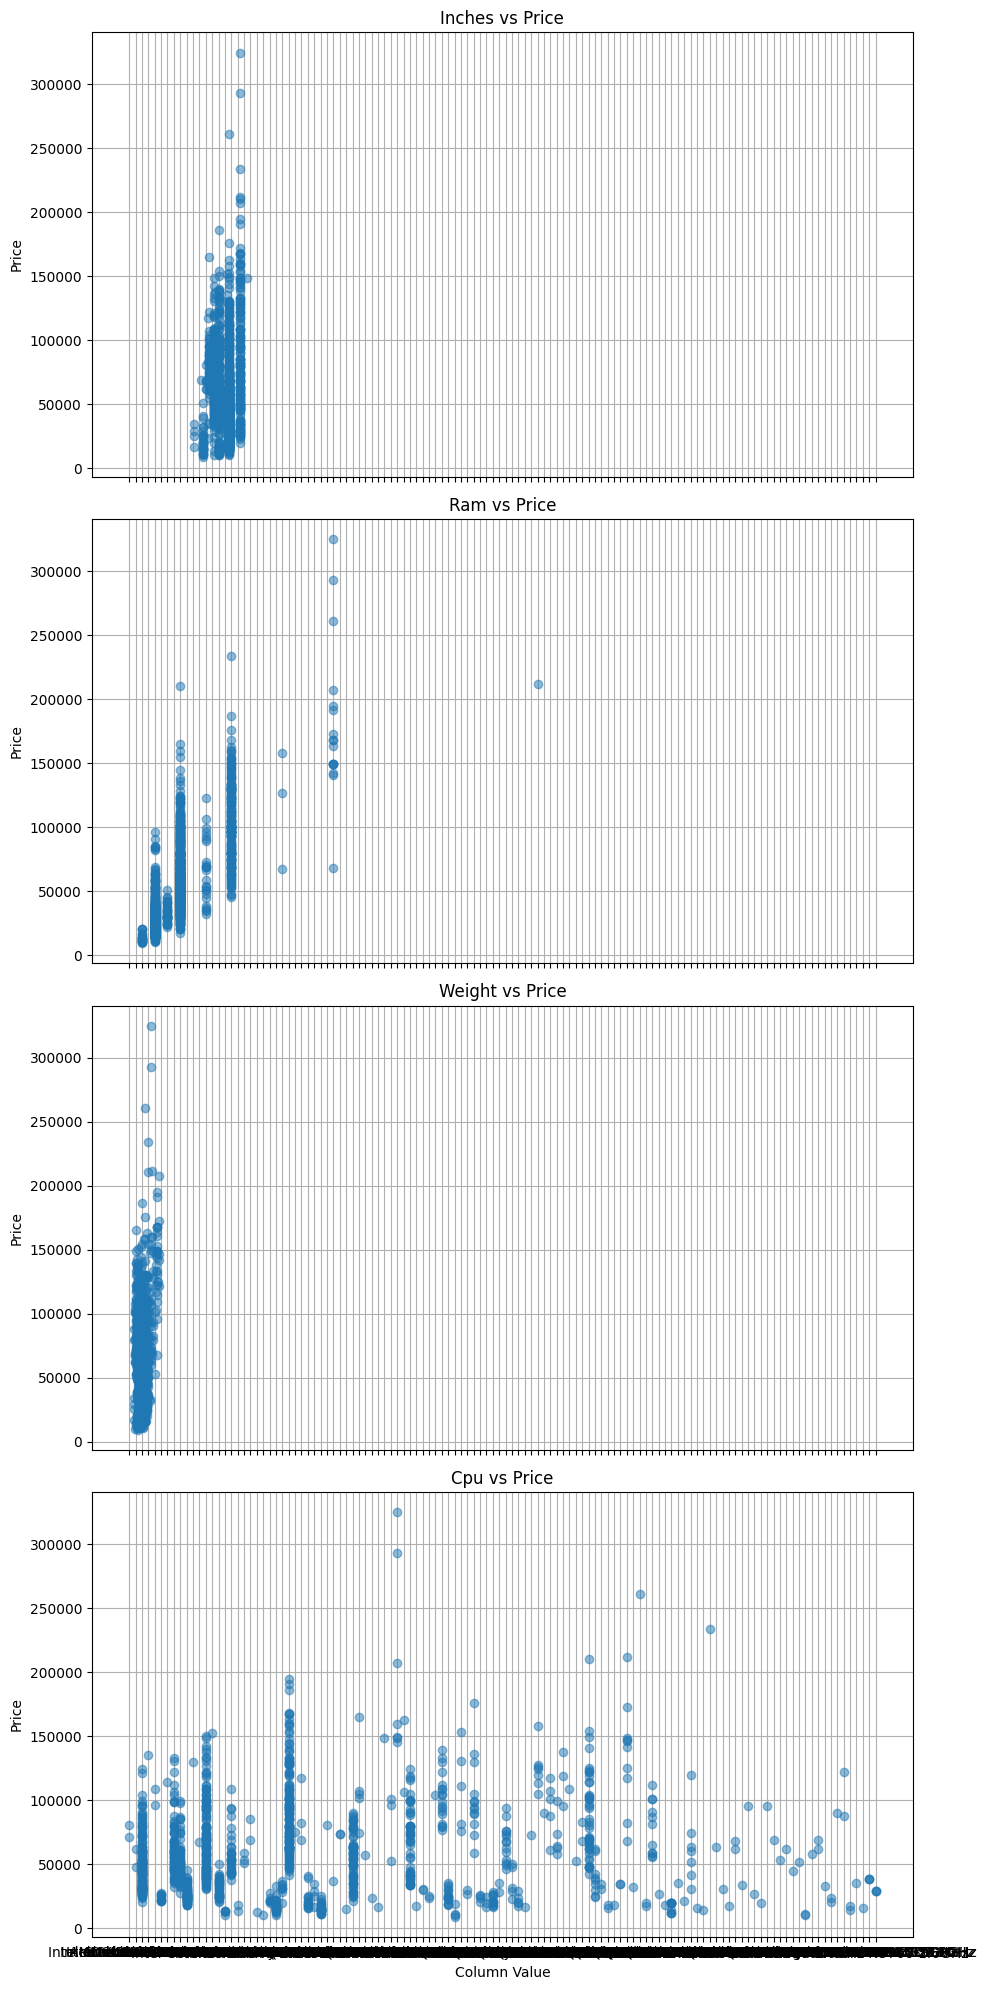

In [110]:
# Example usage including specific columns
columns_of_interest = ['Inches', 'Ram', 'Weight', 'Cpu']
lineplot_impact(df, columns_of_interest)

In [111]:
import matplotlib.pyplot as plt

def average_brand_prices(df):
    """
    Compute and visualize the average prices for each brand.

    Parameters:
    - df: DataFrame
    """
    brand_prices = df.groupby('Company')['Price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    brand_prices.plot(kind='bar', color='skyblue')
    plt.xticks(rotation=45)
    plt.xlabel('Brand')
    plt.ylabel('Average Price')
    plt.title('Average Prices Across Brands')
    plt.show()


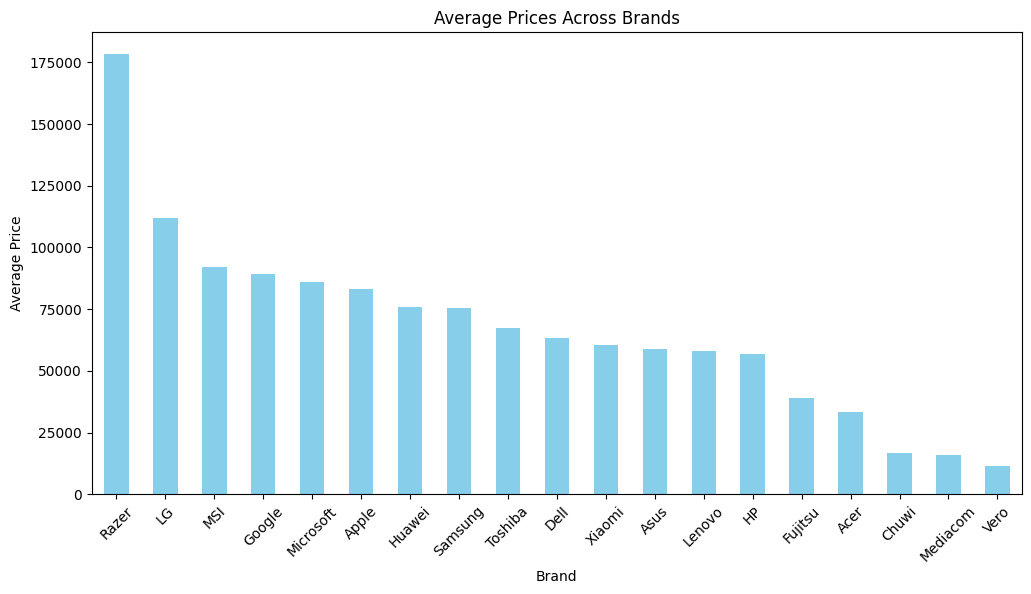

In [112]:
average_brand_prices(df)

In [113]:
import seaborn as sns

def correlation_plot_numeric(df):
    """
    Create a correlation plot for numeric columns in the DataFrame.

    Parameters:
    - df: DataFrame
    """
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Plot for Numeric Columns')
    plt.show()

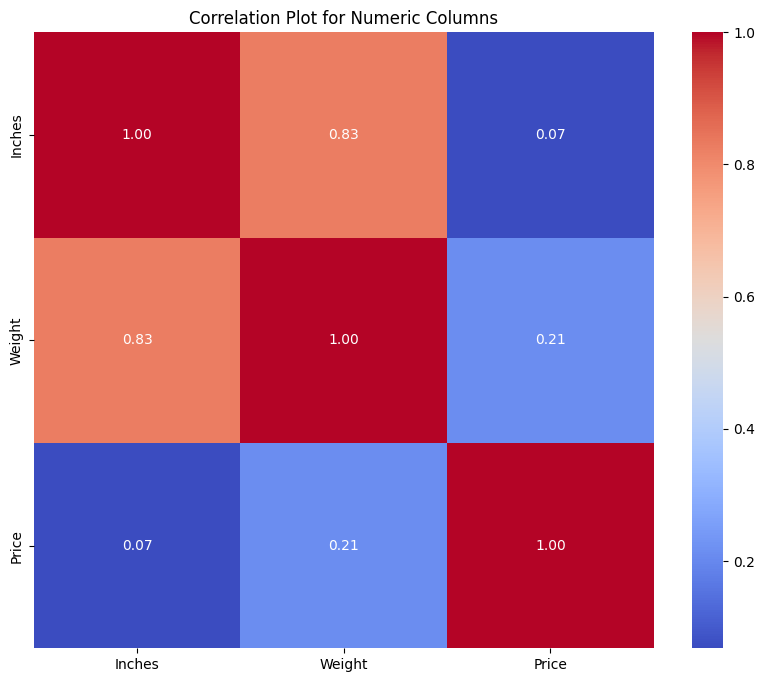

In [114]:
correlation_plot_numeric(df)